In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px #visualize interactive image
import ace_tools_open as tools;

In [2]:
market_data = pd.read_csv("data/market_data.csv", index_col='Date', parse_dates=True)
vix_data = pd.read_csv("data/vix_data.csv", index_col='Date', parse_dates=True)
macro_data = pd.read_csv("data/macro_monthly.csv", index_col='Date', parse_dates=True)
RIR_data = pd.read_csv("data/real_interest_rate.csv", index_col='Date', parse_dates=True)
usd_data = pd.read_csv("data/usd_index.csv", index_col='Date', parse_dates=True)

gold_spot_USD = pd.read_csv("data/gold_spot_WGC.csv", index_col='Date', parse_dates=True)
gold_spot_USD = gold_spot_USD.rename(columns={"USD": "Gold_Spot"})

gpr_data = pd.read_excel("data/data_gpr_export.xls", header = 0)
gpr_data = gpr_data.rename(columns={"month": "Date"})
gpr_data = gpr_data.set_index("Date")
gpr_data = gpr_data[["GPR", "GPRT", "GPRA"]]

gpr_data = gpr_data.resample('D').ffill()
macro_data = macro_data.resample('D').ffill()

In [3]:
datasets = {
    "market": market_data,
    "usd": usd_data,
    "macro": macro_data,
    "rir": RIR_data,
    "vix": vix_data,
    "gpr": gpr_data,
    "gold": gold_spot_USD
}

start_dates = []

for name, df in datasets.items():
    df_valid_start = df.apply(lambda col: col.first_valid_index())
    df_start = df_valid_start.max()  
    start_dates.append(df_start)

latest_start = max(start_dates)
print(f"{latest_start.date()}")

2006-01-02


In [4]:

gold_spot_USD = gold_spot_USD.loc[latest_start:]
market_data = market_data.loc[latest_start:]
usd_data = usd_data.loc[latest_start:]
macro_daily = macro_data.loc[latest_start:]
RIR_data = RIR_data.loc[latest_start:]
vix_data = vix_data.loc[latest_start:]
gpr_daily = gpr_data.loc[latest_start:]

Resample GPR and macro_data to daily with ffill

In [5]:
combined_data = gold_spot_USD \
    .join(market_data, how='left') \
    .join(usd_data, how='left') \
    .join(macro_data, how='left') \
    .join(RIR_data, how='left') \
    .join(vix_data, how='left') \
    .join(gpr_data, how='left')


tools.display_dataframe_to_user(name="Combined dataFrame", dataframe=combined_data)
combined_data.to_csv("data/combined_data.csv")

Combined dataFrame


Loading ITables v2.4.2 from the internet... (need help?)


# 1. Understand - Explore data

## Gold Spot

In [6]:
gold_spot = pd.read_excel(
    "data/Gold_price_averages_in_a range_of_currencies_since_1978.xlsx",
    sheet_name='Monthly_Avg',
    header=5
)
gold_spot = gold_spot.loc[:, ~gold_spot.columns.str.startswith("Unnamed")]
gold_spot["Date"] = pd.to_datetime(gold_spot["Date"], errors="coerce") 
gold_spot.set_index("Date", inplace=True)
print(gold_spot.columns.tolist())

['USD', 'EUR', 'JPY', 'GBP', 'CAD', 'CHF', 'INR', 'CNY', 'TRY', 'SAR', 'IDR', 'AED', 'THB', 'VND', 'EGP', 'KRW', 'RUB', 'ZAR', 'AUD']


In [7]:
gold_spot.isnull().sum()

USD      0
EUR      0
JPY      1
GBP      0
CAD      1
CHF      1
INR      1
CNY     73
TRY     49
SAR      1
IDR      1
AED      1
THB      1
VND    132
EGP    120
KRW      1
RUB    169
ZAR      1
AUD      1
dtype: int64

In [8]:
gold_spot.describe()

,USD,EUR,JPY,GBP,CAD,CHF,INR,CNY,TRY,SAR,IDR,AED,THB,VND,EGP,KRW,RUB,ZAR,AUD
count,569.000000,569.000000,568.000000,569.000000,568.000000,568.000000,568.000000,496.000000,520.000000,568.000000,5.680000e+02,568.000000,568.000000,4.370000e+02,449.000000,5.680000e+02,400.000000,568.000000,568.000000
mean,799.633761,678.210598,99325.684458,543.077985,997.253322,907.011286,44022.345640,5744.604998,6371.255387,2983.963074,8.263982e+06,2942.260964,25614.694511,1.863627e+07,13361.596943,8.798659e+05,50509.960316,8408.641454,1046.322018
std,610.745038,538.403426,76192.909713,479.748257,782.347625,471.401389,52811.914715,4395.808789,17719.000568,2303.240343,1.030856e+07,2242.510622,20949.287101,1.695786e+07,25489.539296,8.219739e+05,59954.589664,11384.910383,860.562782
min,207.830000,129.208100,28312.980370,104.625990,269.548230,378.772810,1852.847000,845.609630,0.083210,754.088370,1.417964e+05,869.396010,4582.177750,1.577365e+06,874.970000,1.111866e+05,148.353480,197.003410,198.596630
25%,355.100000,306.124430,42915.112500,217.932560,458.682720,501.160825,6927.656985,2252.467500,4.910680,1318.378553,7.183258e+05,1304.490970,9691.732638,4.123598e+06,1181.467140,3.055886e+05,7701.481827,996.876285,476.318463
50%,431.280000,380.706050,78104.872740,262.780840,540.229430,762.459850,13666.533900,3452.460000,548.070000,1579.505000,2.893379e+06,1584.290285,13013.080000,1.063084e+07,3599.930000,3.951678e+05,22268.700000,2447.695000,564.665000
75%,1251.850000,1040.920000,134111.395000,858.660000,1478.207500,1224.497500,78140.790000,8473.027500,3053.247500,4707.455000,1.508655e+07,4604.980000,41231.505000,2.972158e+07,10794.640000,1.403668e+06,75953.650000,13560.195000,1520.815000
max,3277.990000,2908.780000,475098.620000,2453.520000,4546.660000,2721.910000,279596.630000,23650.280000,127251.730000,12295.600000,5.396645e+07,12040.040000,108366.900000,8.510954e+07,164659.820000,4.624691e+06,276997.430000,60732.410000,5109.260000


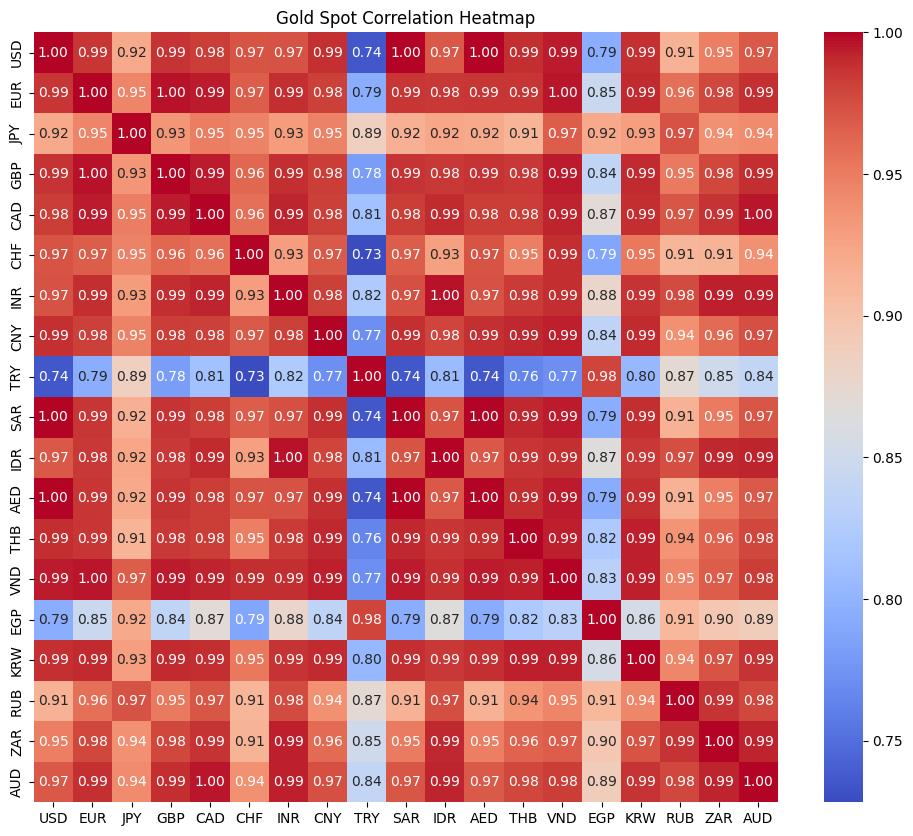

In [9]:
gold_corr = gold_spot.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(gold_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Gold Spot Correlation Heatmap")
plt.show()

In [10]:
full_range = pd.date_range(start=usd_data.index.min(), end=usd_data.index.max(), freq="D")
usd_index_full = usd_data.reindex(full_range)
usd_index_full.index.name = "Date"

In [11]:
usd_data.isnull().sum()

USD_Index    194
dtype: int64

## Combined Data

In [12]:
df = combined_data.copy()

In [13]:
df.info

<bound method DataFrame.info of             Gold_Spot  Crude_Oil  Gold_Futures   Gold_ETF  Silver_Fututes  \
Date                                                                        
2006-01-31     549.86  67.919998    570.799988  56.700001           9.850   
2006-02-28     555.00  61.410000    561.599976  56.070000           9.720   
2006-03-31     557.09  66.629997    581.799988  58.099998          11.480   
2006-04-28     610.65  71.879997    651.799988  65.089996          13.510   
2006-05-31     675.39  71.290001    642.500000  64.230003          12.398   
...               ...        ...           ...        ...             ...   
2025-01-31    2709.69        NaN           NaN        NaN             NaN   
2025-02-28    2894.73        NaN           NaN        NaN             NaN   
2025-03-31    2983.25        NaN           NaN        NaN             NaN   
2025-04-30    3207.48        NaN           NaN        NaN             NaN   
2025-05-30    3277.99        NaN           N

Comment:
- All columns are numericals cols

In [14]:
df.columns

Index(['Gold_Spot', 'Crude_Oil', 'Gold_Futures', 'Gold_ETF', 'Silver_Fututes',
       'S&P_500', 'NASDAQ', 'USD_Index', 'CPI', 'Fed_Funds_Rate', 'M2_Supply',
       'Unemployment', 'Treasury_Yield_10Y', 'Real_Interest_Rate', '^VIX',
       'GPR', 'GPRT', 'GPRA'],
      dtype='object')

In [15]:
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
Gold_Spot,233.0,1419.796395,500.697016,549.860000,1151.400000,1316.180000,1742.620000,3277.990000
Crude_Oil,222.0,72.819505,21.623623,18.840000,54.392501,71.899998,90.480001,140.000000
Gold_Futures,222.0,1376.213514,438.692317,561.599976,1134.074982,1307.350036,1713.550049,2738.300049
Gold_ETF,222.0,131.314234,39.663886,56.070000,109.332502,124.404999,163.802505,253.509995
Silver_Fututes,222.0,20.177275,6.771277,9.720000,15.491750,18.099500,23.924250,48.584000
S&P_500,222.0,2394.074771,1261.245106,735.090027,1364.127502,2059.319946,3042.622559,6032.379883
NASDAQ,222.0,6414.211121,4591.293563,1377.839966,2604.677491,4784.069825,8833.529786,19218.169920
USD_Index,224.0,105.276412,12.149323,85.599900,93.598275,107.104550,115.573375,129.488000
CPI,227.0,244.453101,30.934380,199.300000,219.025500,237.498000,257.977500,316.449000
Fed_Funds_Rate,227.0,1.593128,1.952420,0.050000,0.115000,0.370000,2.400000,5.330000


In [16]:
null_count = df.isnull().sum()
null_percent = (null_count / len(df)) * 100

print(null_count)
print(null_percent)


Gold_Spot              0
Crude_Oil             11
Gold_Futures          11
Gold_ETF              11
Silver_Fututes        11
S&P_500               11
NASDAQ                11
USD_Index              9
CPI                    6
Fed_Funds_Rate         6
M2_Supply              6
Unemployment           6
Treasury_Yield_10Y     6
Real_Interest_Rate    10
^VIX                   5
GPR                    2
GPRT                   2
GPRA                   2
dtype: int64
Gold_Spot             0.000000
Crude_Oil             4.721030
Gold_Futures          4.721030
Gold_ETF              4.721030
Silver_Fututes        4.721030
S&P_500               4.721030
NASDAQ                4.721030
USD_Index             3.862661
CPI                   2.575107
Fed_Funds_Rate        2.575107
M2_Supply             2.575107
Unemployment          2.575107
Treasury_Yield_10Y    2.575107
Real_Interest_Rate    4.291845
^VIX                  2.145923
GPR                   0.858369
GPRT                  0.858369
GPRA      

### Histogram

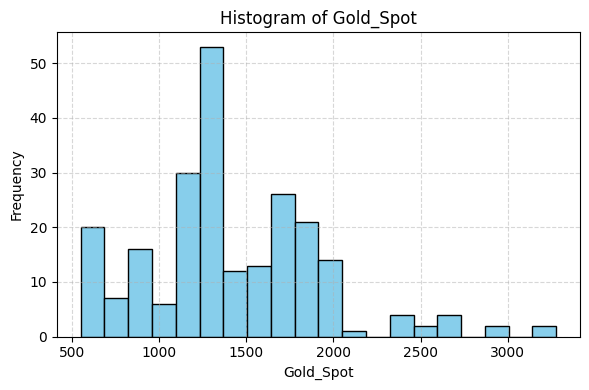

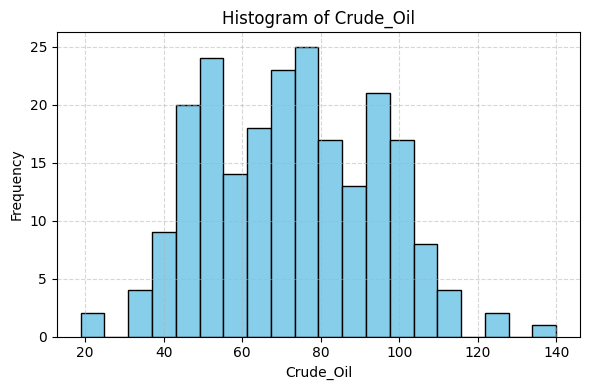

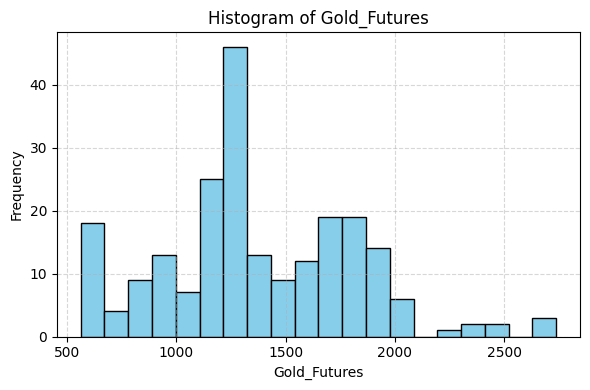

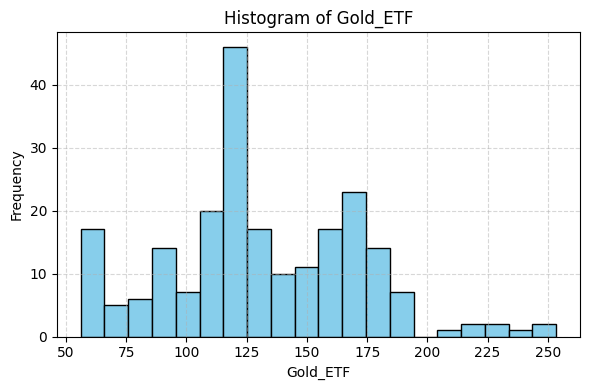

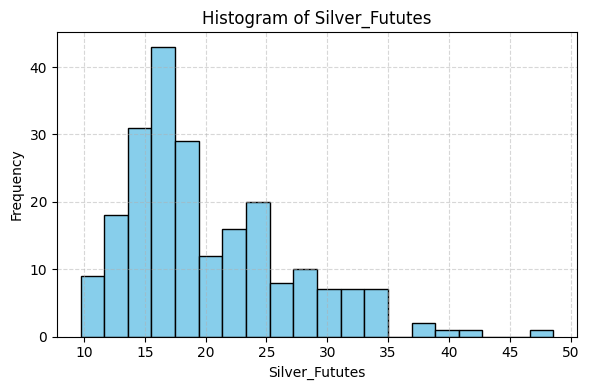

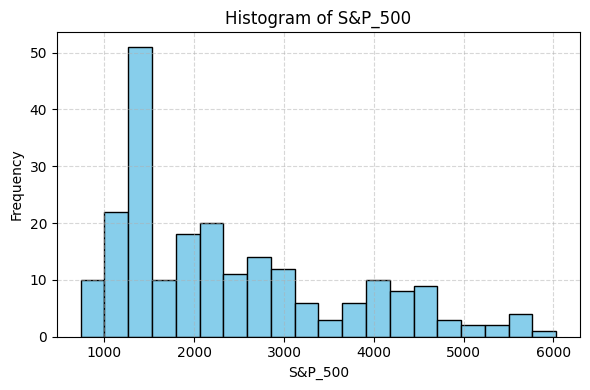

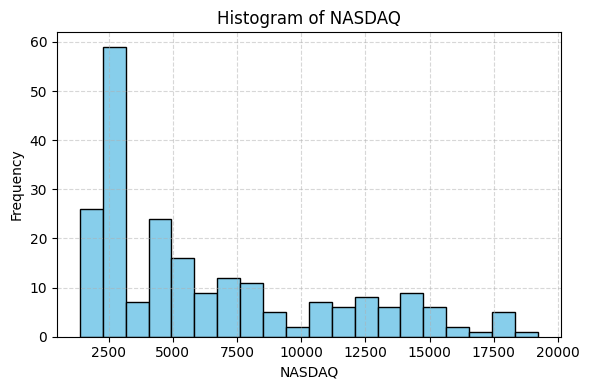

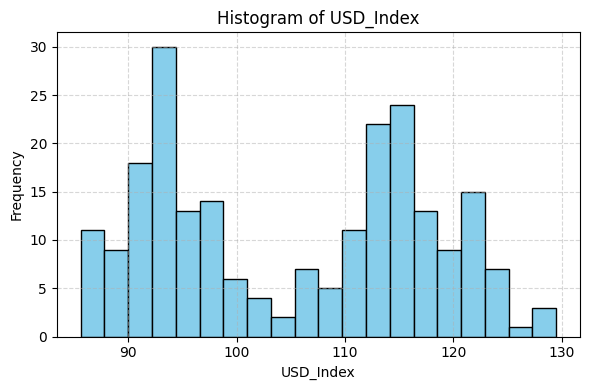

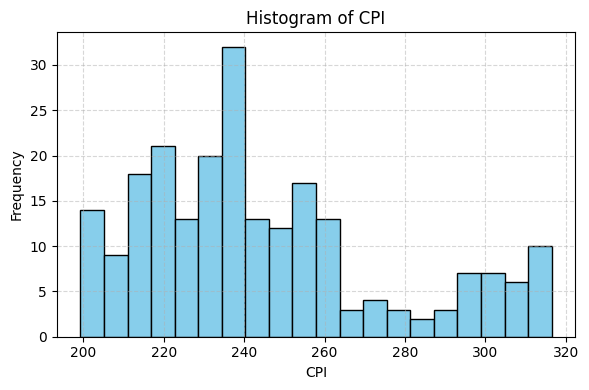

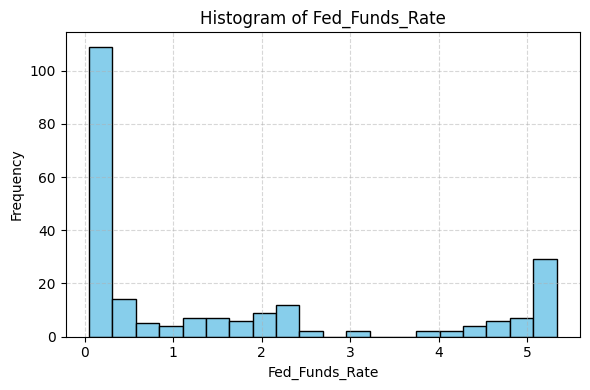

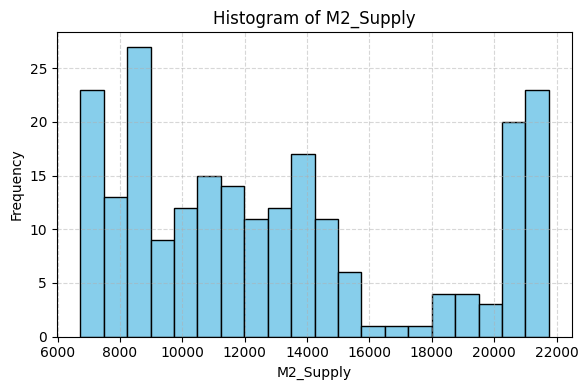

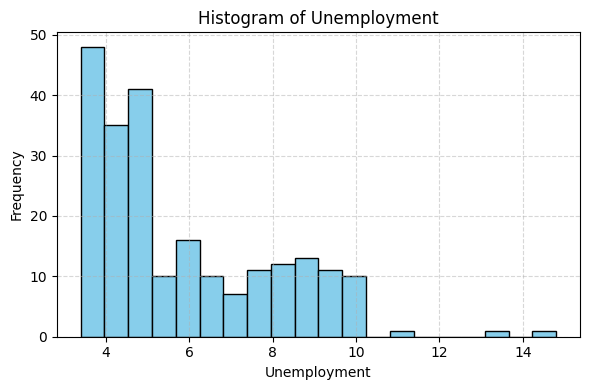

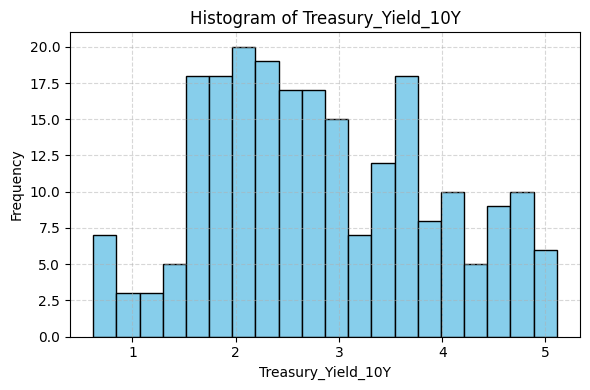

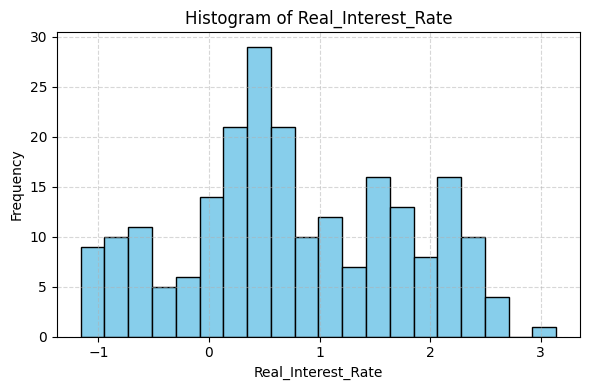

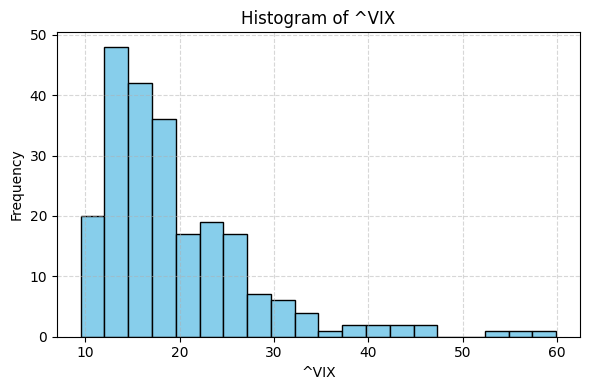

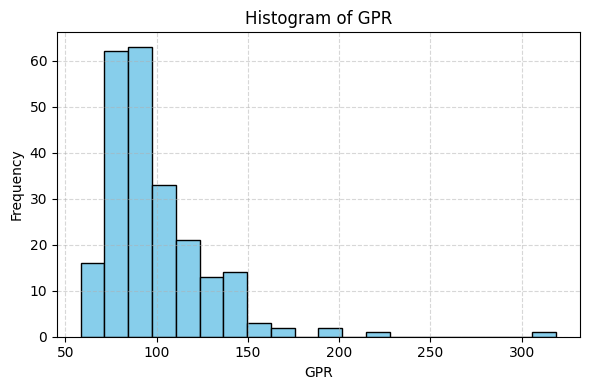

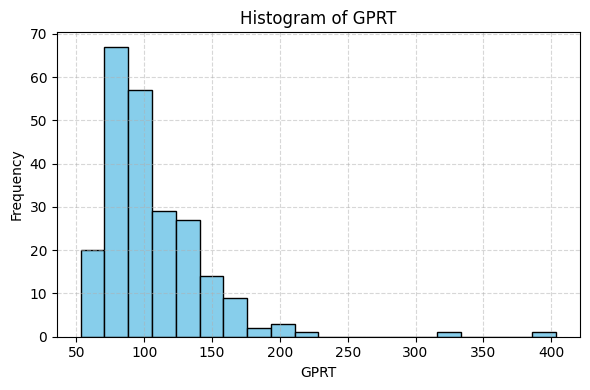

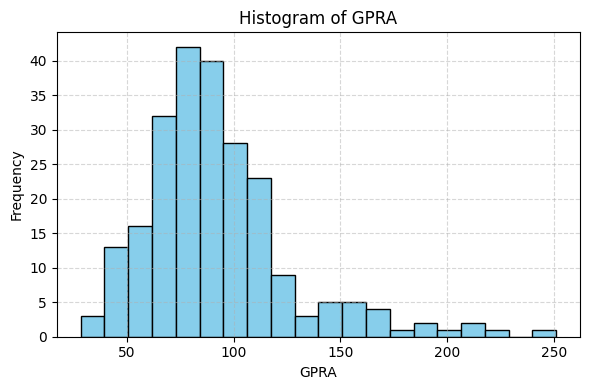

In [17]:
for col in df.columns:
    plt.figure(figsize=(6,4))
    plt.hist(df[col], bins=20, color='skyblue', edgecolor='black')
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

### Boxplot

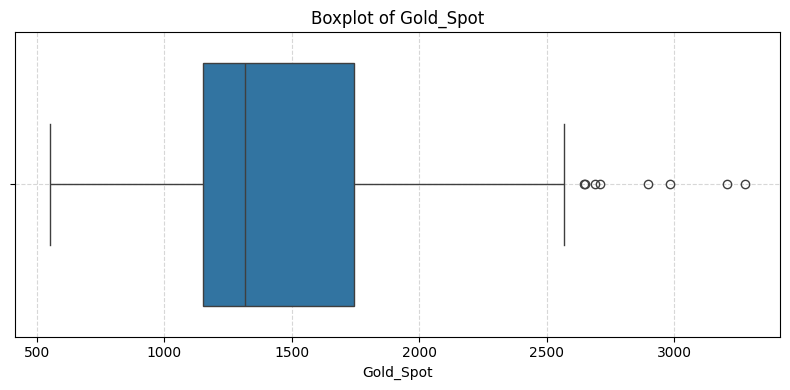

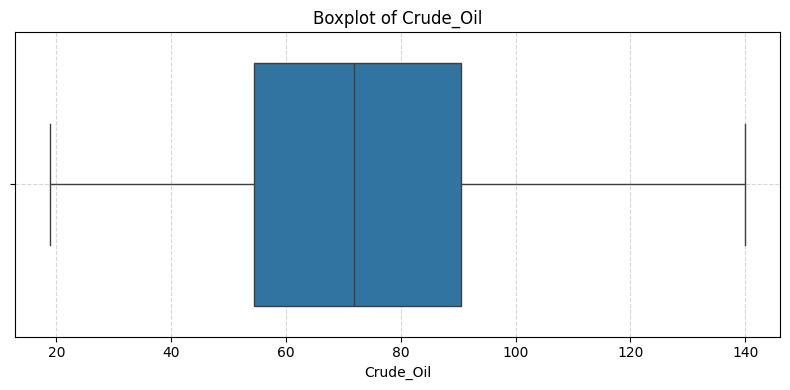

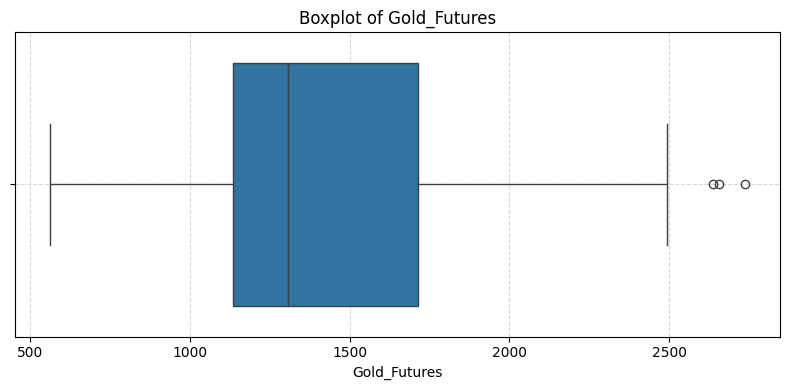

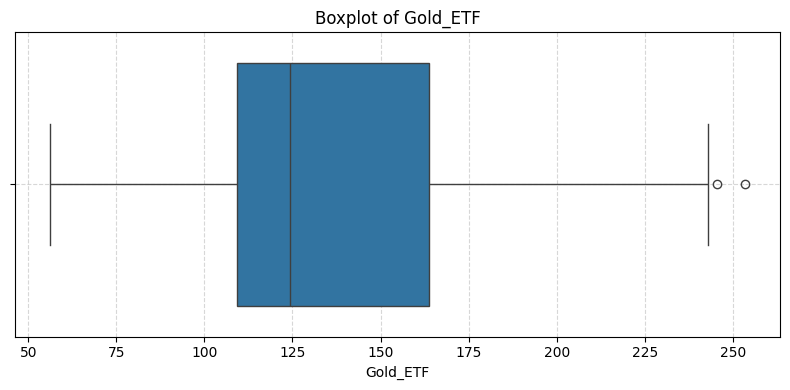

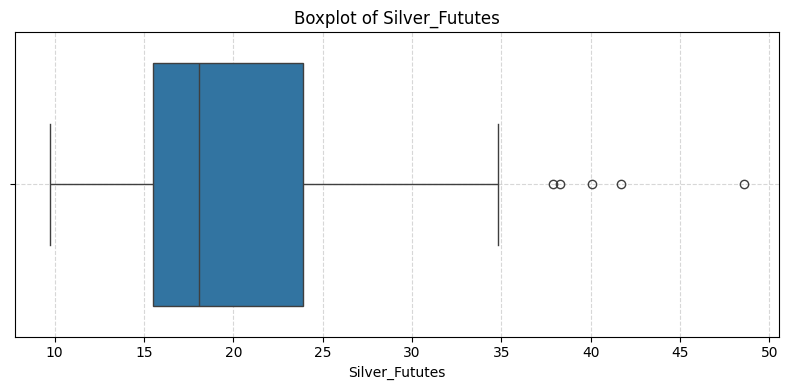

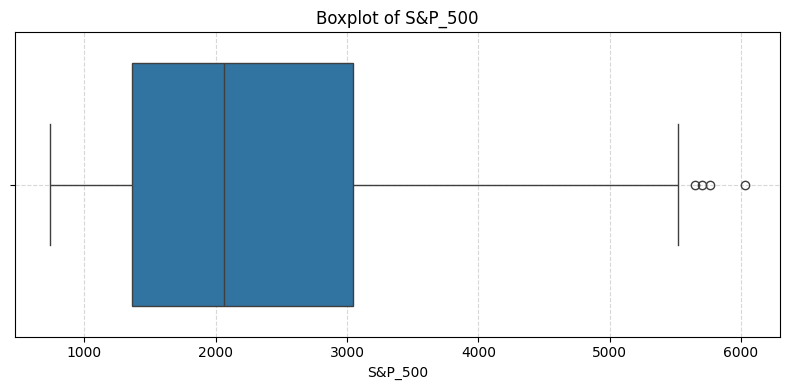

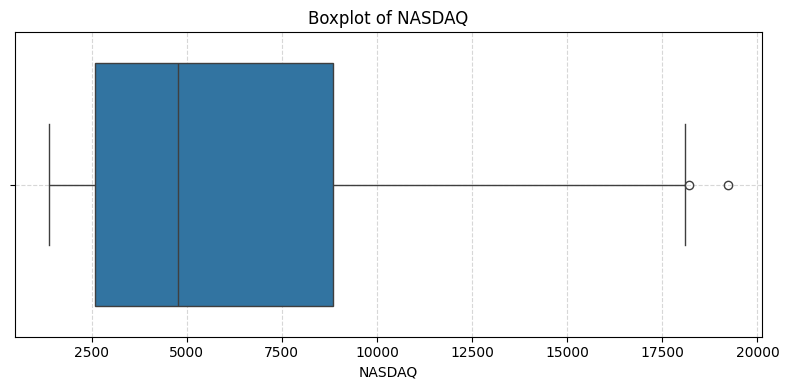

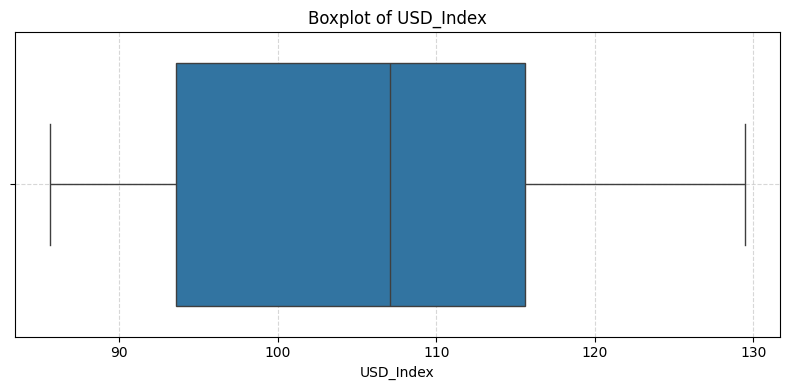

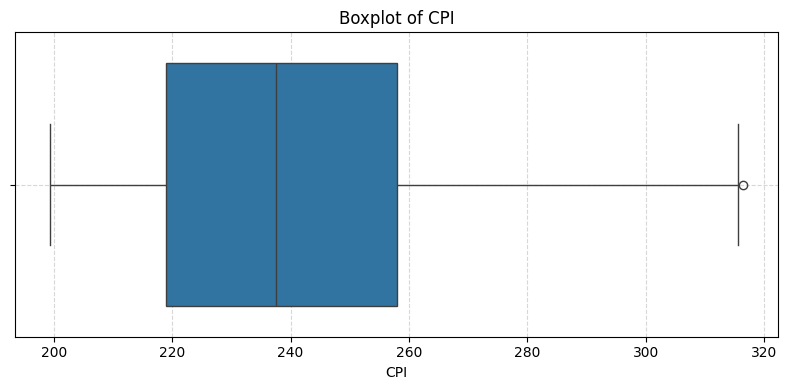

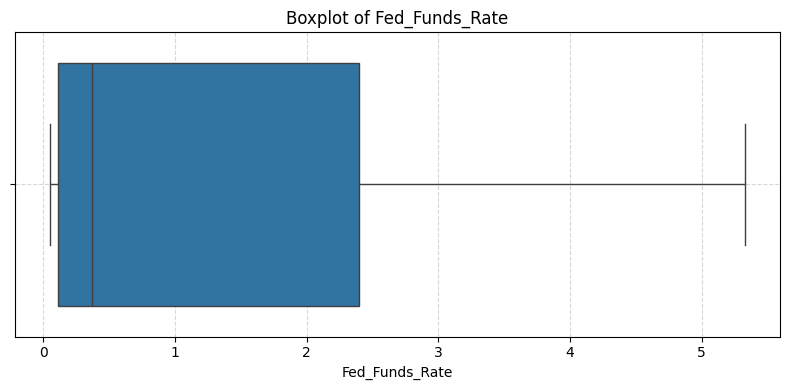

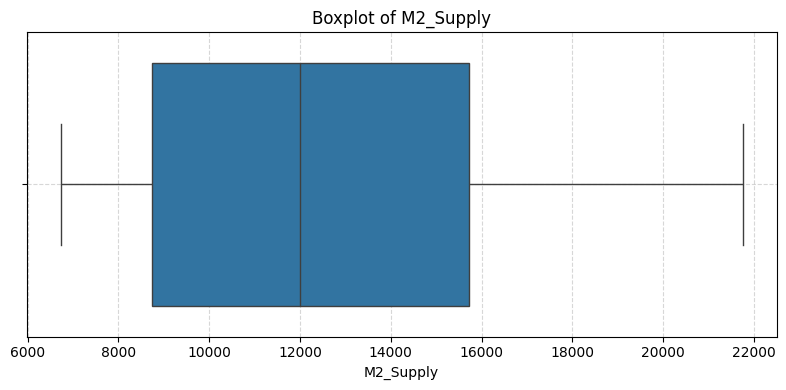

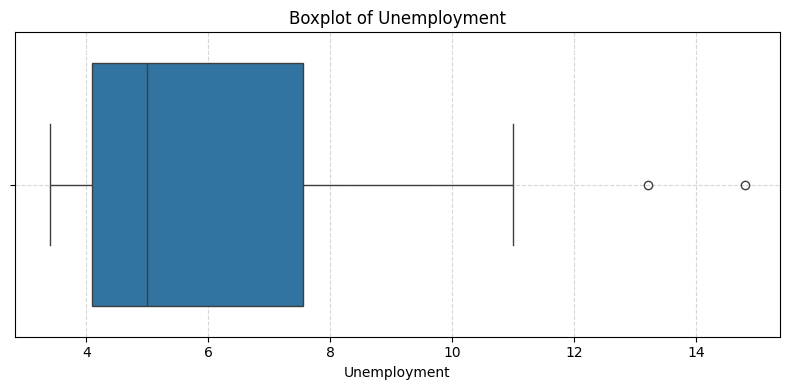

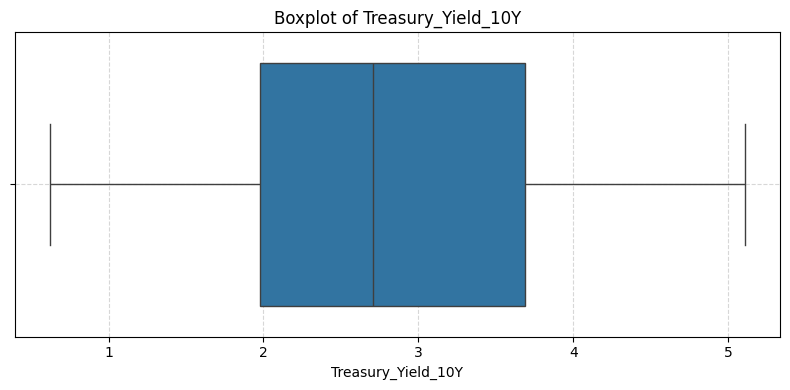

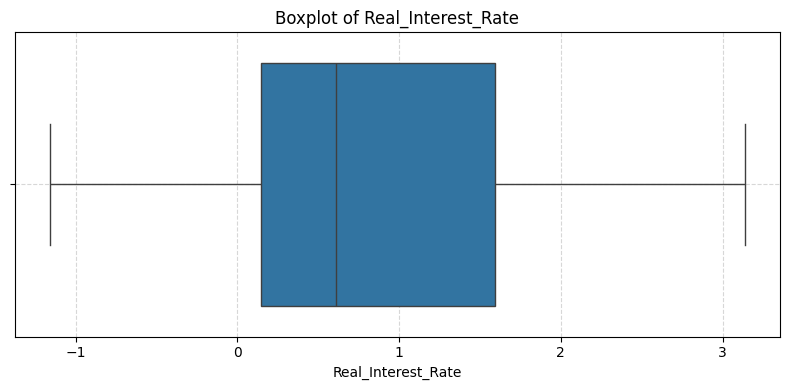

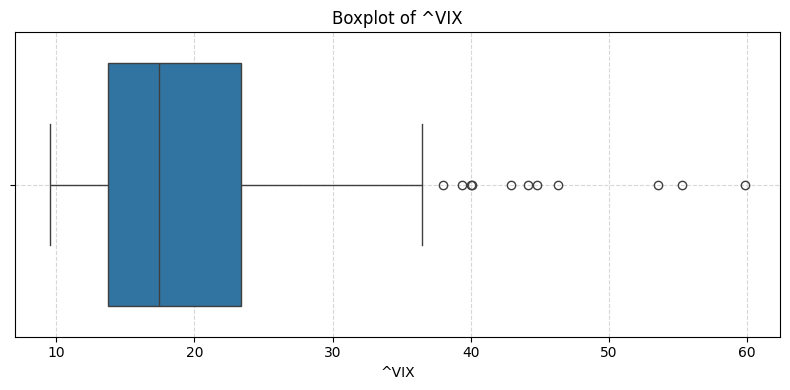

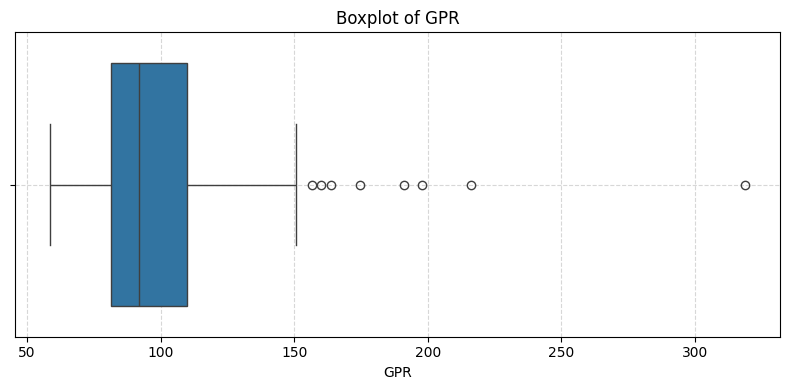

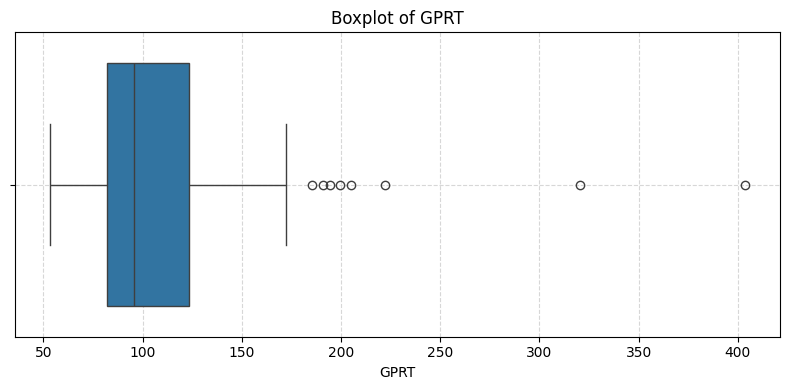

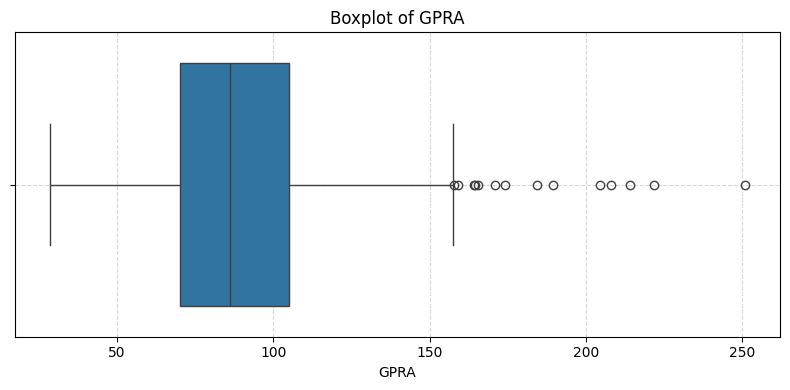

In [18]:
for col in df.columns:
    plt.figure(figsize=(8,4))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.xlabel(col)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

### Correlation

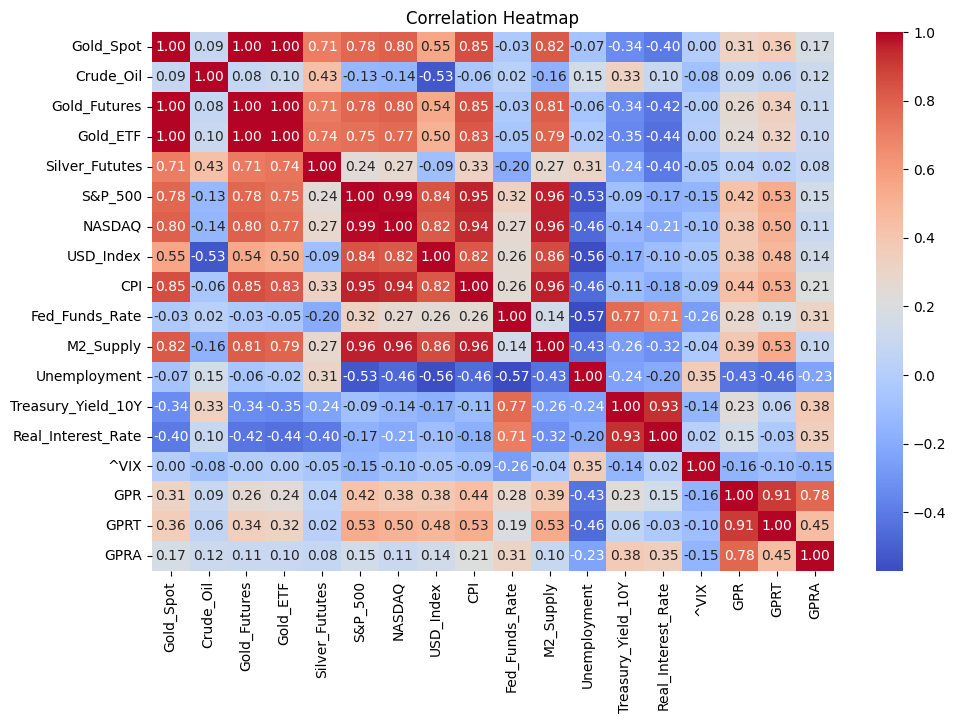

In [19]:
corr_matrix = df.corr()

plt.figure(figsize=(11, 7))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


#### Variables with strong correlation to `Gold_Spot`
| Variable             | Corr with `Gold_Spot` | Recommendation                                   |
| -------------------- | --------------------- | ------------------------------------------------ |
| `CPI`                | 0.85                  | ✅ Strong – closely related to inflation          |
| `M2_Supply`          | 0.82                  | ✅ Strong – supports monetary analysis            |
| `USD_Index`          | 0.55                  | ✅ Moderate – inverse relationship possible       |
| `NASDAQ` / `S&P_500` | \~0.80                | ✅ Keep one – avoid redundancy                    |
| `Silver_Futures`     | 0.71                  | ✅ Strong – precious metal relationship           |
| `Real_Interest_Rate` | -0.40                 | ✅ Negative correlation – highly relevant to gold |
| `GPRT`               | 0.36                  | ✅ Moderate – useful for geopolitical context     |
| `Treasury_Yield_10Y` | -0.34                 | ✅ Relevant – reflects interest rate environment  |

#### Variables with weak or insignificant correlation
| Variable         | Corr with `Gold_Spot` | Recommendation                      |
| ---------------- | --------------------- | ----------------------------------- |
| `Crude_Oil`      | 0.09                  | ❌ Weak – little predictive power    |
| `Fed_Funds_Rate` | -0.03                 | ❌ Very weak – nearly no correlation |
| `^VIX`           | 0.00                  | ❌ Irrelevant – no apparent impact   |
| `GPRA`           | 0.17                  | ❌ Weak – limited value              |


**Comment**

#### Among the three gold-related indicators—`Gold_Spot`, `Gold_Futures`, and `Gold_ETF` choose `Gold_Spot`:
- Represents the actual physical price of gold in global markets.
- Less affected by speculative trading behavior(?).
- Aligns with the monthly frequency of macroeconomic indicators.

#### `S&P_500` vs `NASDAQ`(corr = 0.99)-> `S&P_500`
- `S&P_500` is more representative of the overall U.S. economy.
- `NASDAQ` is tech-heavy and more volatile.

#### `CPI` vs `M2_Supply`(corr = 0.96)-> `CPI`
- `CPI` (Consumer Price Index) directly reflects inflation.
- `M2_Supply` reflects the money supply, which indirectly affects inflation expectations.

#### `GPR` vs `GPRT`(corr = 0.91) -> `GPR`
- `GPR` (Geopolitical Risk) captures general geopolitical tensions such as wars and political instability.
- `GPRT` focuses specifically on geopolitical risks related to terrorism.

### Summary of Selected Variables:
| Feature Pair         | Selected Variable | Reason                                           |
|----------------------|-------------------|--------------------------------------------------|
| `Gold_Futures`, `Gold_ETF`, `Gold_Spot` | `Gold_Spot`        | Ground truth, monthly, less speculative          |
| `S&P_500`, `NASDAQ`  | `S&P_500`         | Broader, more stable                            |
| `CPI`, `M2_Supply`   | `CPI`             | Direct inflation indicator                      |
| `GPR`, `GPRT`        | `GPR`             | Broader geopolitical coverage    

In [20]:
target = 'Gold_Spot'
if target in corr_matrix.columns:
    print(f"corr with {target}:")
    display(corr_matrix[target].sort_values(ascending=False))


corr with Gold_Spot:


Gold_Spot             1.000000
Gold_Futures          0.996687
Gold_ETF              0.995128
CPI                   0.853089
M2_Supply             0.818571
NASDAQ                0.800017
S&P_500               0.780199
Silver_Fututes        0.705529
USD_Index             0.554145
GPRT                  0.359342
GPR                   0.312580
GPRA                  0.171415
Crude_Oil             0.087199
^VIX                  0.003207
Fed_Funds_Rate       -0.026036
Unemployment         -0.069894
Treasury_Yield_10Y   -0.339085
Real_Interest_Rate   -0.404354
Name: Gold_Spot, dtype: float64

In [21]:
# print corr text
printed = set()

for col1 in corr_matrix.columns:
    for col2 in corr_matrix.columns:
        if col1 != col2 and (col2, col1) not in printed:
            corr_value = corr_matrix.loc[col1, col2]
            print(f"Correlation between {col1} and {col2}: {corr_value:.2f}")
            printed.add((col1, col2))

Correlation between Gold_Spot and Crude_Oil: 0.09
Correlation between Gold_Spot and Gold_Futures: 1.00
Correlation between Gold_Spot and Gold_ETF: 1.00
Correlation between Gold_Spot and Silver_Fututes: 0.71
Correlation between Gold_Spot and S&P_500: 0.78
Correlation between Gold_Spot and NASDAQ: 0.80
Correlation between Gold_Spot and USD_Index: 0.55
Correlation between Gold_Spot and CPI: 0.85
Correlation between Gold_Spot and Fed_Funds_Rate: -0.03
Correlation between Gold_Spot and M2_Supply: 0.82
Correlation between Gold_Spot and Unemployment: -0.07
Correlation between Gold_Spot and Treasury_Yield_10Y: -0.34
Correlation between Gold_Spot and Real_Interest_Rate: -0.40
Correlation between Gold_Spot and ^VIX: 0.00
Correlation between Gold_Spot and GPR: 0.31
Correlation between Gold_Spot and GPRT: 0.36
Correlation between Gold_Spot and GPRA: 0.17
Correlation between Crude_Oil and Gold_Futures: 0.08
Correlation between Crude_Oil and Gold_ETF: 0.10
Correlation between Crude_Oil and Silver_Fu

## 2.Pre-processing

In [22]:
df.columns

Index(['Gold_Spot', 'Crude_Oil', 'Gold_Futures', 'Gold_ETF', 'Silver_Fututes',
       'S&P_500', 'NASDAQ', 'USD_Index', 'CPI', 'Fed_Funds_Rate', 'M2_Supply',
       'Unemployment', 'Treasury_Yield_10Y', 'Real_Interest_Rate', '^VIX',
       'GPR', 'GPRT', 'GPRA'],
      dtype='object')

In [23]:
selected_columns = ["Gold_Spot", "Silver_Fututes", "S&P_500", "USD_Index", "CPI", "Treasury_Yield_10Y", "Real_Interest_Rate", "GPR"]
filtered_df = df[selected_columns]
tools.display_dataframe_to_user(name="Filtered Data", dataframe=filtered_df)
filtered_df.to_csv("data/filtered_data.csv")

Filtered Data


Loading ITables v2.4.2 from the internet... (need help?)
